#I apply my model after select top 7 features  and then copy the result in seperate notbook as requird

In [80]:
!pip install keras scikit-learn


In [81]:
!pip install tensorflow scikit-learn


according to paper :


  - The number of hidden neurons should be between the size of the input layer and the size of the output layer.
  - The number of hidden neurons should be 2/3 of the size of the input layer plus 2/3 of the size of the output layer.
  - The number of hidden neurons should be less than twice the size of the input layer.
  -  they used BPNN+ Batch noramlization


In [82]:
!pip install torch


In [83]:
import torch

In [84]:
train_x, test_x, train_y, test_y = data_split(df)


train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)


train_x = torch.from_numpy(train_x_scaled).float()
train_y = torch.squeeze(torch.from_numpy(train_y.to_numpy()).float())

test_x = torch.from_numpy(test_x_scaled).float()
test_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

torch.Size([428, 8]) torch.Size([428])
torch.Size([108, 8]) torch.Size([108])


# Building BPNN

In [86]:
class bpnn(nn.Module):
  def __init__(self, input, hid1, hid2, hid3, numclases):
    super(bpnn, self).__init__()
    #  y = Wx + b
    self.fc1 = nn.Linear(input, hid1)
    self.batch_norm1 = nn.BatchNorm1d(num_features=hid1)
    self.fc2 = nn.Linear(hid1, hid2)
    self.batch_norm2 = nn.BatchNorm1d(num_features=hid2)
    self.fc3 = nn.Linear(hid2, hid3)
    self.batch_norm3 = nn.BatchNorm1d(num_features=hid3)
    self.fc4 = nn.Linear(hid3, numclass)

  def forward(self, x):
    x = F.sigmoid(self.fc1(x)) # for regularization
    x = self.batch_norm1(x)
    x = F.sigmoid(self.fc2(x))
    x = self.batch_norm2(x)
    x = F.sigmoid(self.fc3(x))
    x = self.batch_norm3(x)
    x = F.sigmoid(self.fc4(x))
    return x

BPNNo n training data using cross-entropy loss and the Adam optimizer. It shuffles the data, processes it in batches, and updates the model weights after each batch. The accuracy and loss are calculated for both training and testing . The training stops once the test accuracy reaches 0.89 (the max acc they reach)

In [87]:
input = train_x.shape[1]
hid1 = 64
hid2 = 32
hid3 = 16
numclass = 2
epochs = 10000
batch = 16
lrate = 0.001

modl = bpnn(input, hid1, hid2, hid3, numclass)

criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(modl.parameters(), lr=lrate)

train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []
epoch_list = []

for epoch in range(epochs):
  shuffle_indices = np.random.permutation(np.arange(train_y.shape[0]))
  source = train_x[shuffle_indices]
  target = train_y[shuffle_indices]

  for batch_i in range(0, len(source)//batch):
    start_i = batch_i * batch
    source_batch = source[start_i:start_i + batch]
    target_batch = target[start_i:start_i + batch]
    train_pred = modl(source_batch)
    train_pred = torch.squeeze(train_pred)
    losses = criterion(train_pred, target_batch.type(torch.LongTensor))
    optim.zero_grad()
    losses.backward()
    optim.step()

  train_pred_np = torch.argmax(train_pred, axis=1).numpy()
  train_acc = accuracy_score(target_batch, train_pred_np)

  test_pred = modl(test_x)
  test_pred = torch.squeeze(test_pred)

  test_loss = criterion(test_pred, test_y.type(torch.LongTensor))

  test_pred_np = torch.argmax(test_pred, axis=1).numpy()
  test_acc = accuracy_score(test_y, test_pred_np)

  if (epoch+1) % 50 == 0:
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    train_loss_list.append(losses.item())
    test_loss_list.append(test_loss.item())
    epoch_list.append(epoch)

  if test_acc >= 0.89:
    print(f'Training: Losses: {losses.item():.10f}, Accuracy: {train_acc}')
    print(f'Testing: Losses: {test_loss.item():.10f}, Accuracy: {test_acc}')
    break

  if (epoch+1) % 100 == 0:
    print(f'Epochs [{epoch+1}/{epochs}]')
    print(f'Training: Losses: {losses.item():.10f}, Accuracy: {train_acc}')
    print(f'Testing: Losses: {test_loss.item():.10f}, Accuracy: {test_acc}')


Epochs [100/10000]
Training: Losses: 0.6596770883, Accuracy: 0.625
Testing: Losses: 0.5175370574, Accuracy: 0.7777777777777778
Epochs [200/10000]
Training: Losses: 0.4975780845, Accuracy: 0.8125
Testing: Losses: 0.5176874399, Accuracy: 0.7870370370370371
Epochs [300/10000]
Training: Losses: 0.4704343677, Accuracy: 0.8125
Testing: Losses: 0.5192906857, Accuracy: 0.7870370370370371
Epochs [400/10000]
Training: Losses: 0.5224730968, Accuracy: 0.75
Testing: Losses: 0.5149999261, Accuracy: 0.7870370370370371
Epochs [500/10000]
Training: Losses: 0.3835206032, Accuracy: 0.9375
Testing: Losses: 0.5237009525, Accuracy: 0.7777777777777778
Epochs [600/10000]
Training: Losses: 0.5268338919, Accuracy: 0.8125
Testing: Losses: 0.5126167536, Accuracy: 0.8055555555555556
Epochs [700/10000]
Training: Losses: 0.5913425088, Accuracy: 0.6875
Testing: Losses: 0.5166503787, Accuracy: 0.7777777777777778
Epochs [800/10000]
Training: Losses: 0.3940720260, Accuracy: 0.9375
Testing: Losses: 0.5074127913, Accuracy

#ploting

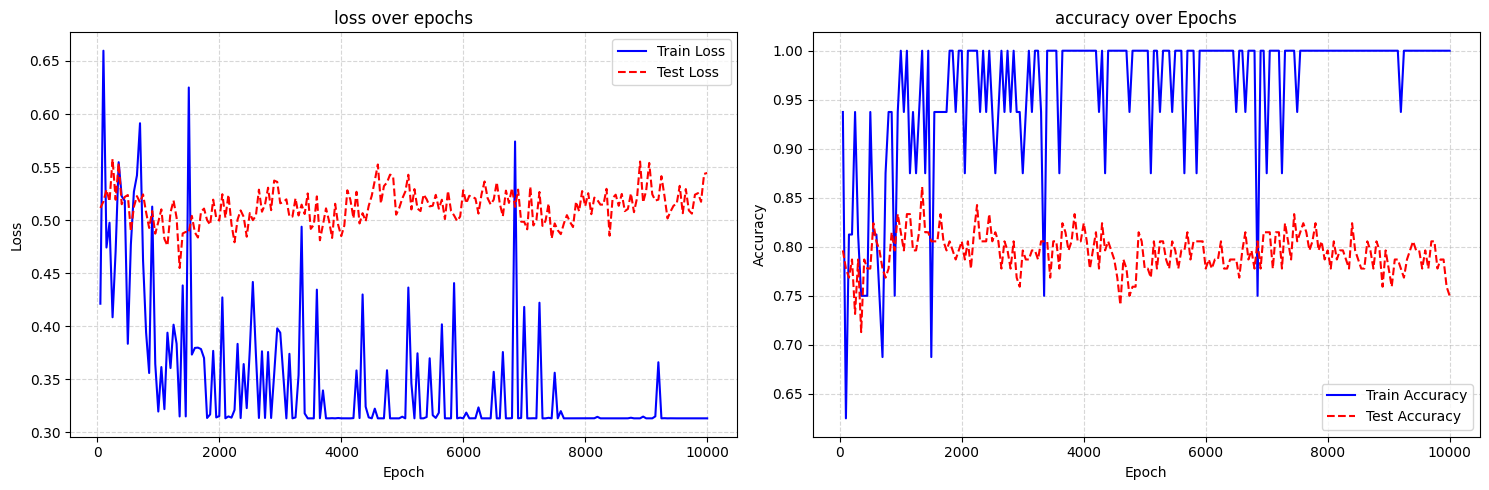

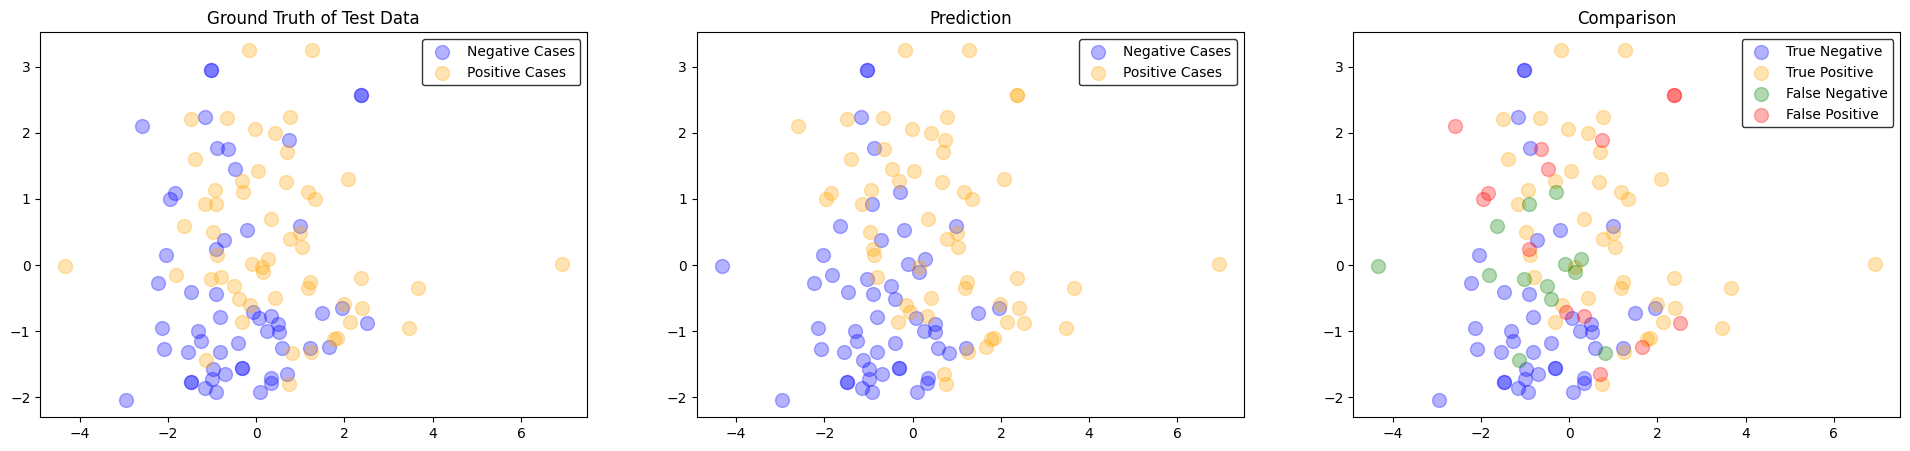

In [88]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(epoch_list, train_loss_list, 'b-', label='Train Loss')
axs[0].plot(epoch_list, test_loss_list, 'r--', label='Test Loss')
axs[0].set_title("loss over epochs", fontsize=12)
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].grid(True, linestyle='--', alpha=0.5)
axs[0].legend()

axs[1].plot(epoch_list, train_acc_list, 'b-', label='Train Accuracy')
axs[1].plot(epoch_list, test_acc_list, 'r--', label='Test Accuracy')
axs[1].set_title("accuracy over Epochs", fontsize=12)
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].grid(True, linestyle='--', alpha=0.5)
axs[1].legend()

plt.tight_layout()
plt.show()

pca_plot(test_x_scaled, test_y, test_pred_np, 100, 1)


In [89]:
!pip install lime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 44.1 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 2.8.8
    Uninstalling networkx-2.8.8:
      Successfully uninstalled networkx-2.8.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyartemis 0.1.5 requires networkx<3.0.0,>=2.8.8, but you have networkx 3.4.2 which is incompatible.


# XAI

## SHAP

  0%|          | 0/1 [00:00<?, ?it/s]

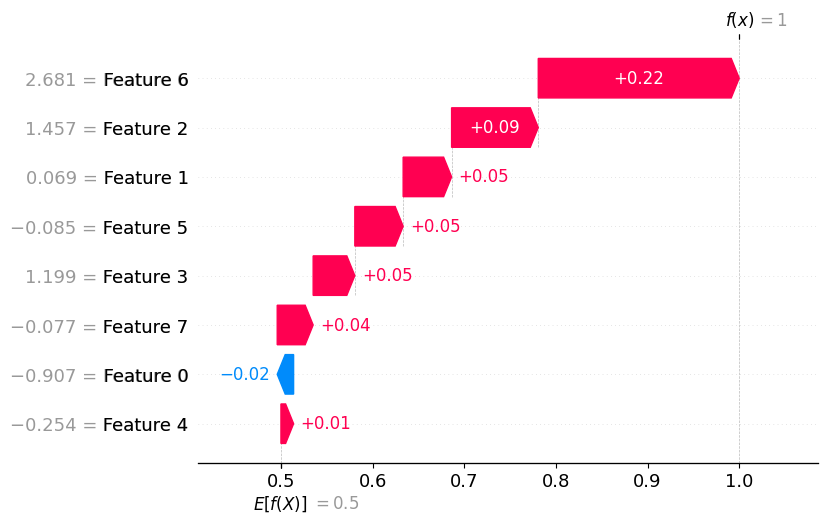

In [90]:
import shap
import torch

def predict_proba(x_numpy):
    x_tensor = torch.from_numpy(x_numpy).float()
    with torch.no_grad():
        return modl(x_tensor).detach().numpy()

sample_idx = 10
sample_instance = test_x_scaled[sample_idx].reshape(1, -1)

modl.eval()
explainer = shap.KernelExplainer(predict_proba, train_x_scaled[:100])
explanation = explainer(sample_instance)
# access for the desired instance and class
shap_values = explanation.values[0][:,1]
shap.initjs()
# I select the first explanation for the first sample and the desired class (for examplle class 1).
shap.plots.waterfall(explanation[0][:,1])


LIME

In [91]:
import lime
import lime.lime_tabular

In [92]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=train_x_scaled,
    feature_names=[f"Feature {i}" for i in range(train_x_scaled.shape[1])],
    class_names=["Class 0", "Class 1"],
    mode="classification"
)
lime_exp = lime_explainer.explain_instance(sample_instance[0], predict_proba)
lime_exp.show_in_notebook(show_table=True)

In [93]:
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

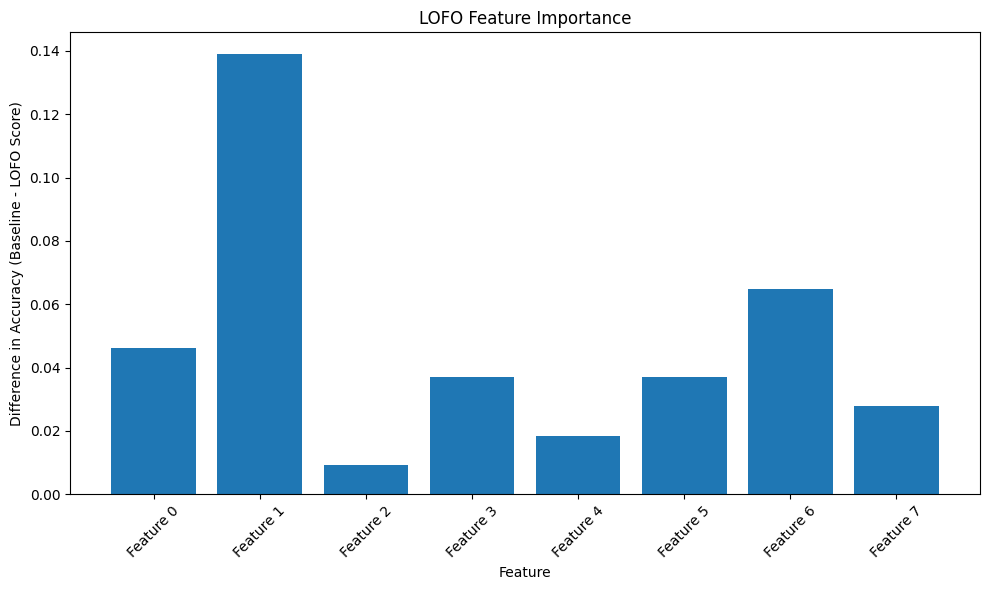

In [94]:
baseline = accuracy_score(test_y.numpy(), modl(torch.from_numpy(test_x_scaled).float()).detach().numpy().argmax(axis=1))
lofo_scores = {}

for col in range(test_x_scaled.shape[1]):
    X_lofo = np.delete(test_x_scaled, col, axis=1)

    modl_lofo = bpnn(input=X_lofo.shape[1], hid1=64, hid2=32, hid3=16, numclases=2)
    modl_lofo.eval()

    X_lofo_tensor = torch.from_numpy(X_lofo).float()
    target_tensor = test_y.long()
    criterion = nn.CrossEntropyLoss()
    optim = torch.optim.Adam(modl_lofo.parameters(), lr=0.001)

    for epoch in range(100):
        optim.zero_grad()
        output = modl_lofo(X_lofo_tensor)
        loss = criterion(output, target_tensor)
        loss.backward()
        optim.step()

    lofo_score = accuracy_score(test_y.numpy(), modl_lofo(X_lofo_tensor).detach().numpy().argmax(axis=1))
    lofo_scores[col] = baseline - lofo_score

plt.figure(figsize=(10, 6))
plt.bar(range(len(lofo_scores)), lofo_scores.values(), tick_label=[f"Feature {i}" for i in lofo_scores.keys()])
plt.xlabel("Feature")
plt.ylabel("Difference in Accuracy (Baseline - LOFO Score)")
plt.title("LOFO Feature Importance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [106]:
!pip install artemis
!pip install pyartemis

from artemis.interactions_methods.model_agnostic import FriedmanHStatisticMethod

100%|██████████| 20/20 [00:00<00:00, 1001.64it/s]


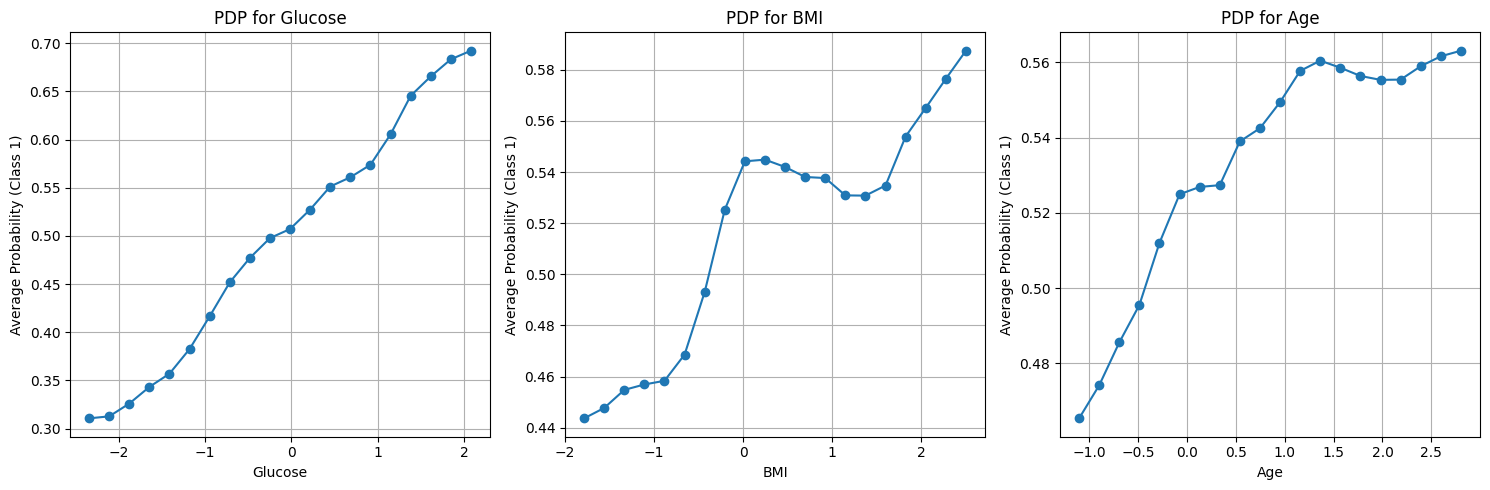

100%|██████████| 10/10 [00:00<00:00, 95.48it/s]


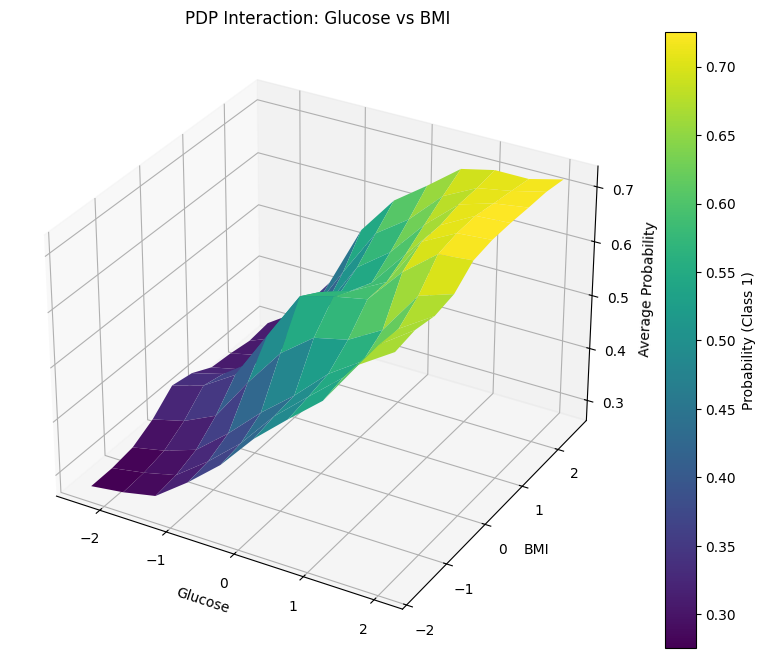

In [117]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm


def pdp(model, X, feature_index, grid_resolution=20):

    feature_values = np.linspace(np.percentile(X[:, feature_index], 1),
                                np.percentile(X[:, feature_index], 99),
                                grid_resolution)

    preds = []

    for value in tqdm(feature_values):
        X_modified = X.copy()
        X_modified[:, feature_index] = value


        with torch.no_grad():
            X_tensor = torch.from_numpy(X_modified).float()
            outputs = model(X_tensor)
            probas = torch.softmax(outputs, dim=1)[:, 1]
            preds.append(probas.numpy().mean())

    return feature_values, np.array(preds)


selected_features = ['Glucose', 'BMI', 'Age']
feature_indices = [df.columns.get_loc(f) for f in selected_features]


plt.figure(figsize=(15, 5))
for i, (feature, idx) in enumerate(zip(selected_features, feature_indices)):
    values, preds = pdp(modl, train_x_scaled, idx)

    plt.subplot(1, 3, i+1)
    plt.plot(values, preds, marker='o')
    plt.title(f'PDP for {feature}')
    plt.xlabel(feature)
    plt.ylabel('Average Probability (Class 1)')
    plt.grid(True)

plt.tight_layout()
plt.show()


def pdp_2d(model, X, feature_indices, grid_resolution=10):

    x_values = np.linspace(np.percentile(X[:, feature_indices[0]], 1),
                          np.percentile(X[:, feature_indices[0]], 99),
                          grid_resolution)
    y_values = np.linspace(np.percentile(X[:, feature_indices[1]], 1),
                          np.percentile(X[:, feature_indices[1]], 99),
                          grid_resolution)

    results = np.zeros((grid_resolution, grid_resolution))

    for i, x in enumerate(tqdm(x_values)):
        for j, y in enumerate(y_values):
            X_modified = X.copy()
            X_modified[:, feature_indices[0]] = x
            X_modified[:, feature_indices[1]] = y

            with torch.no_grad():
                X_tensor = torch.from_numpy(X_modified).float()
                outputs = model(X_tensor)
                probas = torch.softmax(outputs, dim=1)[:, 1]
                results[i, j] = probas.numpy().mean()

    return x_values, y_values, results

if len(feature_indices) >= 2:
    x_vals, y_vals, z = pdp_2d(modl, train_x_scaled, feature_indices[:2])

    XX, YY = np.meshgrid(x_vals, y_vals)

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(XX, YY, z.T, cmap='viridis')
    fig.colorbar(surf, label='Probability (Class 1)')
    ax.set_xlabel(selected_features[0])
    ax.set_ylabel(selected_features[1])
    ax.set_zlabel('Average Probability')
    plt.title(f'PDP Interaction: {selected_features[0]} vs {selected_features[1]}')
    plt.show()